In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import matthews_corrcoef
import optuna

In [2]:
df = pd.read_csv('datasets/train.csv', index_col='id', nrows=500000)

In [3]:
df.describe()

,cap-diameter,stem-height,stem-width
count,500000.000000,500000.000000,500000.000000
mean,6.306940,6.349803,11.145688
std,4.655807,2.704382,8.093111
min,0.410000,0.000000,0.000000
25%,3.310000,4.670000,4.970000
50%,5.750000,5.880000,9.640000
75%,8.230000,7.410000,15.630000
max,80.670000,57.220000,102.480000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   class                 500000 non-null  object 
 1   cap-diameter          500000 non-null  float64
 2   cap-shape             499990 non-null  object 
 3   cap-surface           392516 non-null  object 
 4   cap-color             499999 non-null  object 
 5   does-bruise-or-bleed  499999 non-null  object 
 6   gill-attachment       415889 non-null  object 
 7   gill-spacing          298885 non-null  object 
 8   gill-color            499994 non-null  object 
 9   stem-height           500000 non-null  float64
 10  stem-width            500000 non-null  float64
 11  stem-root             57545 non-null   object 
 12  stem-surface          182300 non-null  object 
 13  stem-color            499994 non-null  object 
 14  veil-type             25510 non-null   object 
 15  veil-

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df['has-ring'].value_counts()

has-ring
f    379936
t    120040
c         4
h         3
r         2
g         2
l         2
p         2
y         1
e         1
s         1
Name: count, dtype: int64

In [7]:
df.shape

(500000, 21)

In [8]:
X = df.drop('class', axis=1)
y = df['class']

In [9]:
y_counts = y.value_counts()

([<matplotlib.patches.Wedge at 0x7f7e395d0a30>,
 [Text(-0.1639291704226337, 1.087716519633929, 'p'),
  Text(0.16392906858326206, -1.087716534982081, 'e')],
 [Text(-0.08941591113961836, 0.5932999198003248, '54.76%'),
  Text(0.08941585559087022, -0.593299928172044, '45.24%')])

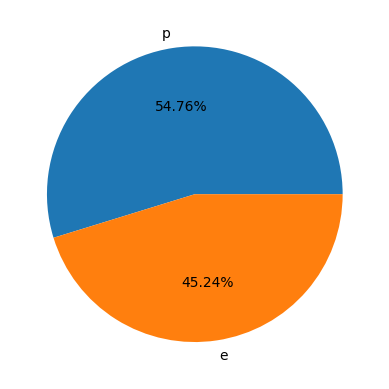

In [10]:
plt.pie(y_counts, labels=y_counts.index, autopct="%.2f%%")

### Preprocessing

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [12]:
num_var = X.select_dtypes(['float64']).columns.to_list()
cat_var = X.select_dtypes(['object']).columns.to_list()
transformer = ColumnTransformer([('num', StandardScaler(), num_var),
                                 ('cat', OneHotEncoder(drop='first'), cat_var)])

In [13]:
cat_var

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [14]:
X_trans = transformer.fit_transform(X)

In [15]:
num_cols = transformer.named_transformers_['num'].get_feature_names_out().tolist()
cat_cols = transformer.named_transformers_['cat'].get_feature_names_out().tolist()
columns = num_cols + cat_cols

In [16]:
X_trans # X_trans is a sparse matrix

<500000x386 sparse matrix of type '<class 'numpy.float64'>'
	with 9752313 stored elements in Compressed Sparse Row format>

In [17]:
X_trans = pd.DataFrame.sparse.from_spmatrix(X_trans, columns=columns)
X_trans.head()

,cap-diameter,stem-height,stem-width,cap-shape_2.85,cap-shape_21.56,cap-shape_3.55,cap-shape_3.6,cap-shape_4.22,cap-shape_5 f,cap-shape_7 x,...,habitat_t,habitat_u,habitat_w,habitat_x,habitat_y,habitat_z,habitat_nan,season_s,season_u,season_w
0,0.535474,-0.680305,0.524436,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.385957,-0.576769,-0.576502,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2,0.135972,0.184958,-0.150213,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
3,-0.521272,-0.809725,-0.570324,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.0,0
4,-0.098144,-1.101843,-0.344205,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
y_trans = y.map({'p': 1, 'e': 0})

### Feature Selection

In [19]:
from sklearn.feature_selection import VarianceThreshold

In [35]:
sel = VarianceThreshold(threshold=0.001)
X_sel = sel.fit_transform(X_trans)

In [22]:
print(f'X_sel.shape: {X_sel.shape}; X_trans.shape: {X_trans.shape}')

X_sel.shape: (500000, 124); X_trans.shape: (500000, 386)


In [29]:
#X_sel = pd.DataFrame.sparse.from_spmatrix(X_sel, columns=sel.get_feature_names_out())

### XGBoost

In [28]:
import xgboost as xgb

/home/estaciolima/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y_trans, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "eta": trial.suggest_float("eta", 0.01, 0.4),
        "max_depth": trial.suggest_int("max_depth", 4, 32),
        "lambda": trial.suggest_float("lambda", 0.1, 2),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.8, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1)
    }


    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    error = matthews_corrcoef(y_test, y_pred)
    return error

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

study.best_params

[I 2024-08-06 14:06:23,140] A new study created in memory with name: no-name-1547e79e-9a0b-48e4-bd61-98bb57a145b6
[I 2024-08-06 14:06:30,438] Trial 0 finished with value: 0.9829548029102037 and parameters: {'eta': 0.05981368107640856, 'max_depth': 15, 'lambda': 0.810015049904259, 'min_child_weight': 6.0482501692080355, 'subsample': 0.9043165273279566, 'colsample_bytree': 0.7191472403962718}. Best is trial 0 with value: 0.9829548029102037.
[I 2024-08-06 14:06:34,451] Trial 1 finished with value: 0.9832553221097566 and parameters: {'eta': 0.2767596199650324, 'max_depth': 17, 'lambda': 0.2898530599920244, 'min_child_weight': 5.945046380278719, 'subsample': 0.8845353740305516, 'colsample_bytree': 0.914786588665642}. Best is trial 1 with value: 0.9832553221097566.
[I 2024-08-06 14:06:38,875] Trial 2 finished with value: 0.9824445486343168 and parameters: {'eta': 0.33789736381500446, 'max_depth': 24, 'lambda': 0.6259958665101106, 'min_child_weight': 8.333642605028972, 'subsample': 0.82397460

{'eta': 0.14125997609617025,
 'max_depth': 20,
 'lambda': 0.9674532237426338,
 'min_child_weight': 4.082841046413778,
 'subsample': 0.8776652508409101,
 'colsample_bytree': 0.7417850753962157}

In [28]:
study.best_value

0.9841811251007532

In [29]:
xgb_params = {'eta': 0.14125997609617025,
 'max_depth': 20,
 'lambda': 0.9674532237426338,
 'min_child_weight': 4.082841046413778,
 'subsample': 0.8776652508409101,
 'colsample_bytree': 0.7417850753962157}

dict

### LightGBM

In [24]:
import lightgbm as lgb

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y_trans, test_size=0.2, random_state=42)

def objective(trial):
    # Hyperparameters to tune
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    error = matthews_corrcoef(y_test, y_pred)
    return error

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

study.best_params

[I 2024-08-06 17:20:59,723] A new study created in memory with name: no-name-9ceb4714-9d13-4c8e-a63d-c56961d9c76c
[I 2024-08-06 17:21:02,044] Trial 0 finished with value: 0.9830129925789962 and parameters: {'num_leaves': 59, 'learning_rate': 0.18885966422225564, 'feature_fraction': 0.9709096780166482, 'bagging_fraction': 0.8264771086289683, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 0 with value: 0.9830129925789962.
[I 2024-08-06 17:21:03,986] Trial 1 finished with value: 0.9823846809583773 and parameters: {'num_leaves': 125, 'learning_rate': 0.23356604221274813, 'feature_fraction': 0.8721366799438168, 'bagging_fraction': 0.539560543250033, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 0 with value: 0.9830129925789962.
[I 2024-08-06 17:21:05,570] Trial 2 finished with value: 0.9827098606317859 and parameters: {'num_leaves': 42, 'learning_rate': 0.24689831942672652, 'feature_fraction': 0.7690732570198016, 'bagging_fraction': 0.8039939453622327, 'bagging_fre

{'num_leaves': 140,
 'learning_rate': 0.09154835441455036,
 'feature_fraction': 0.5806836555634359,
 'bagging_fraction': 0.9884282473485232,
 'bagging_freq': 7,
 'min_child_samples': 98}

In [40]:
study.best_value

0.9842018429989348

In [41]:
lgbm_params = {'num_leaves': 140,
 'learning_rate': 0.09154835441455036,
 'feature_fraction': 0.5806836555634359,
 'bagging_fraction': 0.9884282473485232,
 'bagging_freq': 7,
 'min_child_samples': 98,
 'verbose': -1}

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y_trans, test_size=0.2, random_state=42)

def objective(trial):
    # Hyperparameters to tune
    params = {
        'objective': 'binary',
        'boosting_type': 'dart',
        'num_leaves': trial.suggest_int('num_leaves', 20, 250),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'verbose': -1
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    error = matthews_corrcoef(y_test, y_pred)
    return error

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

print(f'Best params: {study.best_params}')
print(f'Best value: {study.best_value}')

[I 2024-08-07 17:20:17,066] A new study created in memory with name: no-name-083e7505-6e80-47d6-b249-d7dbc2cc10c1
[I 2024-08-07 17:20:23,107] Trial 0 finished with value: 0.982569963793631 and parameters: {'num_leaves': 91, 'learning_rate': 0.32156679381138387, 'feature_fraction': 0.5384905648784845, 'bagging_fraction': 0.8238291518917783, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 0 with value: 0.982569963793631.
[I 2024-08-07 17:20:28,346] Trial 1 finished with value: 0.9810992228818343 and parameters: {'num_leaves': 51, 'learning_rate': 0.16205834939063732, 'feature_fraction': 0.5560727020236879, 'bagging_fraction': 0.9090150459522306, 'bagging_freq': 5, 'min_child_samples': 99}. Best is trial 0 with value: 0.982569963793631.
[I 2024-08-07 17:20:33,158] Trial 2 finished with value: 0.9781357040313676 and parameters: {'num_leaves': 37, 'learning_rate': 0.15844586422797324, 'feature_fraction': 0.7447411988469266, 'bagging_fraction': 0.9663139982251948, 'bagging_freq': 

Best params: {'num_leaves': 236, 'learning_rate': 0.17745389398567907, 'feature_fraction': 0.5590877395748017, 'bagging_fraction': 0.9950711489582625, 'bagging_freq': 1, 'min_child_samples': 85}
Best value: 0.984666860633202


In [33]:
study.best_params

{'num_leaves': 236,
 'learning_rate': 0.17745389398567907,
 'feature_fraction': 0.5590877395748017,
 'bagging_fraction': 0.9950711489582625,
 'bagging_freq': 1,
 'min_child_samples': 85}

In [34]:
dart_params = {'num_leaves': 236,
 'learning_rate': 0.17745389398567907,
 'feature_fraction': 0.5590877395748017,
 'bagging_fraction': 0.9950711489582625,
 'bagging_freq': 1,
 'min_child_samples': 85}

### CatBoost

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y_trans, test_size=0.2, random_state=42)

def objective(trial):
    # Hyperparameters to tune
    params = {
        'iterations': trial.suggest_int('iterations', 80, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 12),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'verbose': 0  # Set verbose to 0 to prevent printing output during training
    }

    model = cb.CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    error = matthews_corrcoef(y_test, y_pred)
    return error

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

print(f'Best params: {study.best_params}')
print(f'Best value: {study.best_value}')

[I 2024-08-07 21:03:40,479] A new study created in memory with name: no-name-94fdccaa-222f-4368-a30b-afcf4c55892b
[I 2024-08-07 21:03:46,071] Trial 0 finished with value: 0.9827905787185568 and parameters: {'iterations': 86, 'learning_rate': 0.12372378642345407, 'depth': 9, 'border_count': 38}. Best is trial 0 with value: 0.9827905787185568.
[I 2024-08-07 21:03:52,545] Trial 1 finished with value: 0.9829335600674758 and parameters: {'iterations': 194, 'learning_rate': 0.19307174605801988, 'depth': 6, 'border_count': 127}. Best is trial 1 with value: 0.9829335600674758.
[I 2024-08-07 21:03:56,328] Trial 2 finished with value: 0.9725085354418537 and parameters: {'iterations': 121, 'learning_rate': 0.09587399866142422, 'depth': 5, 'border_count': 89}. Best is trial 1 with value: 0.9829335600674758.
[I 2024-08-07 21:04:07,004] Trial 3 finished with value: 0.9835781902214972 and parameters: {'iterations': 122, 'learning_rate': 0.25999346455913347, 'depth': 11, 'border_count': 34}. Best is t

Best params: {'iterations': 159, 'learning_rate': 0.17379868130781356, 'depth': 11, 'border_count': 80}
Best value: 0.9842849054324642


In [38]:
catboost_params = {'iterations': 159, 'learning_rate': 0.17379868130781356, 'depth': 11, 'border_count': 80}

### HistGradientClassifier

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_sel.toarray(), y_trans, test_size=0.2, random_state=42)

def objective(trial):
    # Hyperparameters to tune
    params = {
        'max_iter': trial.suggest_int('max_iter', 80, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 80),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 1),
        'verbose': 0  # Set verbose to 0 to prevent printing output during training
    }

    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    error = matthews_corrcoef(y_test, y_pred)
    return error

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

print(f'Best params: {study.best_params}')
print(f'Best value: {study.best_value}')

[I 2024-08-08 16:19:05,955] A new study created in memory with name: no-name-36c1864d-b4ef-4d97-bfe8-eeab0c9f345f
[I 2024-08-08 16:19:22,798] Trial 0 finished with value: 0.9835562384996367 and parameters: {'max_iter': 195, 'learning_rate': 0.23891711869376503, 'max_depth': 7, 'min_samples_leaf': 22, 'l2_regularization': 0.48258161534011546}. Best is trial 0 with value: 0.9835562384996367.
[I 2024-08-08 16:19:37,418] Trial 1 finished with value: 0.9831950539873359 and parameters: {'max_iter': 162, 'learning_rate': 0.2228505172165706, 'max_depth': 11, 'min_samples_leaf': 63, 'l2_regularization': 0.8130580254735029}. Best is trial 0 with value: 0.9835562384996367.
[I 2024-08-08 16:19:57,422] Trial 2 finished with value: 0.9494900510374813 and parameters: {'max_iter': 198, 'learning_rate': 0.014478307284649654, 'max_depth': 10, 'min_samples_leaf': 26, 'l2_regularization': 0.15416961340944146}. Best is trial 0 with value: 0.9835562384996367.
[I 2024-08-08 16:20:04,169] Trial 3 finished wit

Best params: {'max_iter': 191, 'learning_rate': 0.2644094326309775, 'max_depth': 11, 'min_samples_leaf': 43, 'l2_regularization': 0.6299921631456823}
Best value: 0.9836975790032024


In [26]:
study.best_params

{'max_iter': 191,
 'learning_rate': 0.2644094326309775,
 'max_depth': 11,
 'min_samples_leaf': 43,
 'l2_regularization': 0.6299921631456823}

In [27]:
hist_params = {'max_iter': 191,
 'learning_rate': 0.2644094326309775,
 'max_depth': 11,
 'min_samples_leaf': 43,
 'l2_regularization': 0.6299921631456823}

### Stacking with Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [36]:
oof_preds = {}

def get_oof_predictions(X, y, model):
    kf = KFold(n_splits=5)
    
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]

        print(f'Fold {i}')
        
        model.fit(X_train, y_train)
        oof_preds = model.predict(X_test)

        break
    
    return oof_preds

params = {'max_iter': 191,
 'learning_rate': 0.2644094326309775,
 'max_depth': 11,
 'min_samples_leaf': 43,
 'l2_regularization': 0.6299921631456823}

model = HistGradientBoostingClassifier(**params)

oof_preds['hist'] = get_oof_predictions(X_sel.toarray(), y_trans, model)

Fold 0


In [37]:
oof_preds

{'hist': array([0, 1, 0, ..., 1, 0, 1])}